# Sentiment Analysis of coffee shops reviews 
### By Group 4

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(9.7,6.27)})
sns.set_style("white")
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import re

ModuleNotFoundError: No module named 'pandas'

In [ ]:
df = pd.read_csv('surry_hills_coffee_reviews.csv')
df.head(5)

,page,name,link,thumbnail,rating,date,snippet,images,local_guide,CoffeeShop
0,1,J Wang,https://www.google.com/maps/contrib/1066405393...,https://lh3.googleusercontent.com/a/ALm5wu2QSW...,1.0,10 months ago,Ordered take away lunch and received this burn...,['https://lh5.googleusercontent.com/p/AF1QipNc...,True,Paramount Coffee Project
1,1,Manish Rai,https://www.google.com/maps/contrib/1087306153...,https://lh3.googleusercontent.com/a/ALm5wu0hYM...,1.0,6 months ago,"TLDR/Long story short: Wrong pricing online, o...",['https://lh5.googleusercontent.com/p/AF1QipO-...,NaN,Paramount Coffee Project
2,1,Lisa,https://www.google.com/maps/contrib/1090187054...,https://lh3.googleusercontent.com/a-/ACNPEu-sy...,1.0,3 months ago,Drinks order was taken and drinks never arrive...,NaN,NaN,Paramount Coffee Project
3,1,Angel Manuel,https://www.google.com/maps/contrib/1127216205...,https://lh3.googleusercontent.com/a-/ACNPEu850...,1.0,2 months ago,"I came here twice, poor service. I ordered gre...",NaN,NaN,Paramount Coffee Project
4,1,Jisoo,https://www.google.com/maps/contrib/1168975833...,https://lh3.googleusercontent.com/a/ALm5wu25sD...,1.0,a year ago,We came here because the coffee shop we were g...,['https://lh5.googleusercontent.com/p/AF1QipOG...,NaN,Paramount Coffee Project


## Data exploration

In [ ]:
# Check whether there are some rows with empty review
df[df.snippet.isnull()]

,page,name,link,thumbnail,rating,date,snippet,images,local_guide,CoffeeShop
28,1,Mann Hing Khor,https://www.google.com/maps/contrib/1157018408...,https://lh3.googleusercontent.com/a-/ACNPEu91h...,2.0,a year ago,NaN,NaN,True,Neighbourhood Speciality coffee


In [ ]:
# Remove empty record
df = df[~df.snippet.isnull()].reset_index(drop=True)

In [ ]:
# Check duplicates
df[df.duplicated('snippet')]

,page,name,link,thumbnail,rating,date,snippet,images,local_guide,CoffeeShop


In [ ]:
# Explore distribution of scoring
df.groupby('rating')['snippet'].count()

rating
1.0    258
2.0    128
3.0    137
4.0    166
5.0    475
Name: snippet, dtype: int64

In [ ]:
data = df.groupby('rating')['snippet'].count()
data

rating
1.0    258
2.0    128
3.0    137
4.0    166
5.0    475
Name: snippet, dtype: int64

In [ ]:
data = data.to_frame().reset_index()

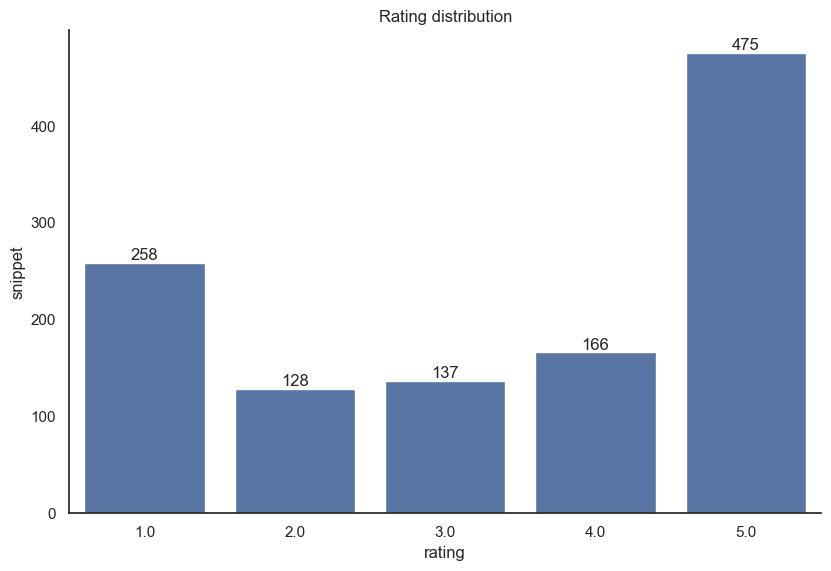

In [ ]:
# Explore distribution of scoring
ax = sns.barplot(data=data, x='rating', y="snippet")
ax.bar_label(ax.containers[0])
ax.set(title='Rating distribution')
sns.despine()

Reviews with score 1.0 and 2.0 will be assigned with negative sentiment, 3.0 and 4.0 will indicate neutral attitude and 5.0 will respond for positive sentiment.

In [ ]:
# Assign labels
df['sentiment']=df['rating'].apply(lambda x: 1 if x==5  else -1 if 0<x<3 else 0)
df['sentiment_desc']=df['rating'].apply(lambda x: 'positive' if x==5  else 'negative' if 0<x<3 else 'neutral')

In [ ]:
#df['sentiment']=df['rating'].apply(lambda x: 1 if x>4  else 0)

In [ ]:
# Check if it works
df[['snippet', 'rating', 'sentiment']].head(5)

,snippet,rating,sentiment
0,Ordered take away lunch and received this burn...,1.0,-1
1,"TLDR/Long story short: Wrong pricing online, o...",1.0,-1
2,Drinks order was taken and drinks never arrive...,1.0,-1
3,"I came here twice, poor service. I ordered gre...",1.0,-1
4,We came here because the coffee shop we were g...,1.0,-1


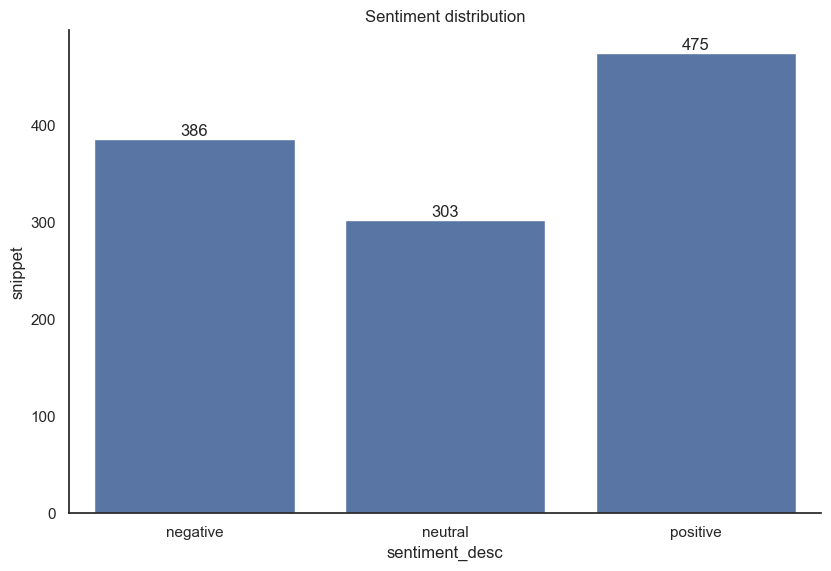

In [ ]:
# Explore distribution of sentiment
data2 = df.groupby('sentiment_desc')['snippet'].count()
data2 = data2.to_frame().reset_index()
ax = sns.barplot(data=data2, x='sentiment_desc', y="snippet")
ax.bar_label(ax.containers[0])
ax.set(title='Sentiment distribution')
sns.despine()

We can conclude that this dataset is pretty balanced. But it depends on the way how labels were assigned to the score.

In [ ]:
data

,rating,snippet
0,1.0,258
1,2.0,128
2,3.0,137
3,4.0,166
4,5.0,475


In [ ]:
negative_prop = round(len(df[df.sentiment==-1])/len(df), 2)
neutral_prop = round(len(df[df.sentiment==0])/len(df), 2)
positive_prop = round(len(df[df.sentiment==1])/len(df), 2)

In [ ]:
target_df = pd.DataFrame({'sentiment': ['negative', 'neutral', 'positive'],
                            'proportions': [negative_prop, neutral_prop, positive_prop]})

In [ ]:
print ('This dataset is balanced: '
       'negative reviews: %s, '
       'neutral reviews: %s, '
       'positive reviews: %s' %
       (str(negative_prop),
        str(neutral_prop),
        str(positive_prop)))

This dataset is balanced: negative reviews: 0.33, neutral reviews: 0.26, positive reviews: 0.41


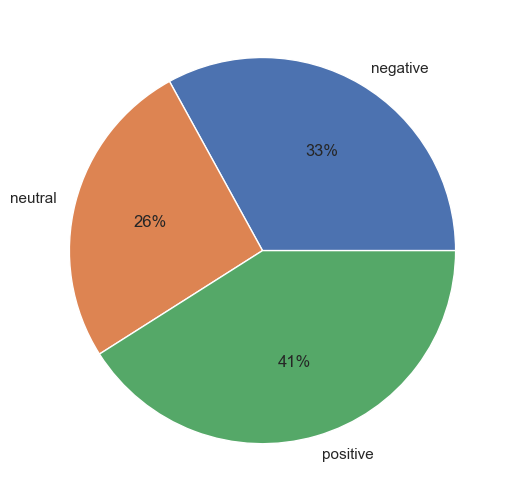

In [ ]:
plt.pie(target_df['proportions'], labels = target_df['sentiment'], autopct='%.0f%%')
plt.show()

## Data Preprocessing

In [ ]:
#Select only needed columns
data = df[['snippet', 'sentiment']]

In [ ]:
data.head(5)

,snippet,sentiment
0,Ordered take away lunch and received this burn...,-1
1,"TLDR/Long story short: Wrong pricing online, o...",-1
2,Drinks order was taken and drinks never arrive...,-1
3,"I came here twice, poor service. I ordered gre...",-1
4,We came here because the coffee shop we were g...,-1


All punctuations should be removed

In [ ]:
# Remove punctuations
data['tidy_snippet'] = data['snippet'].str.replace("[^a-zA-Z#]", " ")

Remove unusufull words using list of english stop words defined in nltk package. Additionally, some custom words releted to coffee,  that could be present in each review, were removed.

In [ ]:
# Prepare list of stops words from nltk
stop_words=stopwords.words('english')

In [ ]:
# Define custom stop words
my_stop_words = ['coffee','cafe', 'food', 'today', 'yesterday', 'place', 'staff', 'breakfast']

In [ ]:
# Combine two lists
stop_words = stop_words + my_stop_words

In [ ]:
# Remove stop words
data['tidy_snippet'] = data['tidy_snippet'].apply(lambda x: ' '.join([w for w in x.lower().split() if w not in stop_words]))

### For the next step there are two options: stemming or lemmatization.

Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.

Both options were checked bellow.



In [ ]:
## Stemming
stemmer=PorterStemmer()
data['stem_snippet']  = data['tidy_snippet'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [ ]:
## Lemmatization
lemmatizer = WordNetLemmatizer()
data['lem_snippet'] = data['tidy_snippet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [ ]:
# Check out differences
data[['tidy_snippet', 'stem_snippet', 'lem_snippet']].head(5)

,tidy_snippet,stem_snippet,lem_snippet
0,ordered take away lunch received burned toasti...,order take away lunch receiv burn toasti (hidd...,ordered take away lunch received burned toasti...
1,"tldr/long story short: wrong pricing online, o...","tldr/long stori short: wrong price online, ove...","tldr/long story short: wrong pricing online, o..."
2,"drinks order taken drinks never arrived, chase...","drink order taken drink never arrived, chase u...","drink order taken drink never arrived, chase u..."
3,"came twice, poor service. ordered green tea, r...","came twice, poor service. order green tea, rec...","came twice, poor service. ordered green tea, r..."
4,came shop gonna go closed. ordered housemade g...,came shop gonna go closed. order housemad gran...,came shop gonna go closed. ordered housemade g...


In [ ]:
# Two X prepared separately
X_stem = data['stem_snippet']
X_lem = data['lem_snippet']
y = data['sentiment']

### Vectorization


Vectorization is the process of converting text into numerical data (vectors), which is vital step in every NLP project.

Two options will be exlored: Vectorization and TD-IDF

1. Count Vectorizer is a way to convert a given set of strings into a frequency representation (Bag of Words).
2. TF-IDF focuses not only on the frequency of words present in the corpus but also provides the importance of the words

In other word, in this project models build on data prepared with 4 different settings will be assessed. Namely:
- Stemmed data prepared witt Count Vectorizer
- Stemmed data prepared with TF-IDF
- Lemmatized data prepared witt Count Vectorizer
- Lemmatized data prepared with TF-IDF

The CountVectorizer and TF-IDF  will choose the 3000 words/features that occur most frequently and drop everything else.


In [ ]:
# Count Vectorizer with stemming
cv_stem=CountVectorizer(max_features=3000)
X_count_vec_stem =cv_stem.fit_transform(X_stem)

In [ ]:
# Count Vectorizer with lemmatization
cv_lem=CountVectorizer(max_features=3000)
X_count_vec_lem = cv_lem.fit_transform(X_lem)

In [ ]:
# TD-IDF with stemming
tfidf_stem =TfidfVectorizer(max_features=3000)
X_tfidf_stem =tfidf_stem.fit_transform(X_stem)

In [ ]:
# TD-IDF with lemmatization data
tfidf_lem =TfidfVectorizer(max_features=3000)
X_tfidf_lem =tfidf_lem.fit_transform(X_lem)

### Data visualization

After cleaning and preparing the data, let's explore most frequent word

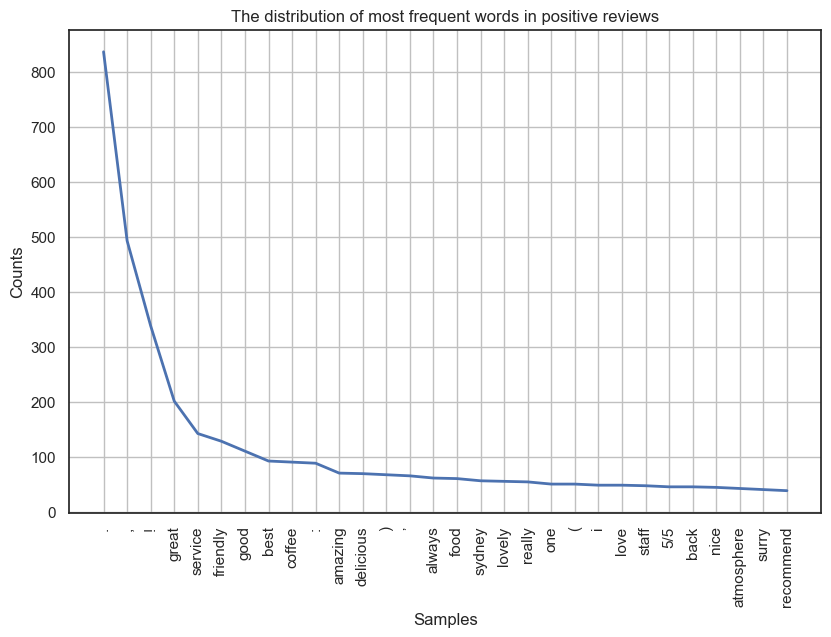

<Axes: title={'center': 'The distribution of most frequent words in positive reviews'}, xlabel='Samples', ylabel='Counts'>

In [ ]:
# Positive words
positive = data[data.sentiment == 1]
a = positive['tidy_snippet'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist_pos = nltk.FreqDist(words)
word_dist_pos.plot(30, cumulative=False, title='The distribution of most frequent words in positive reviews')

But we can also try it with sns bar plot

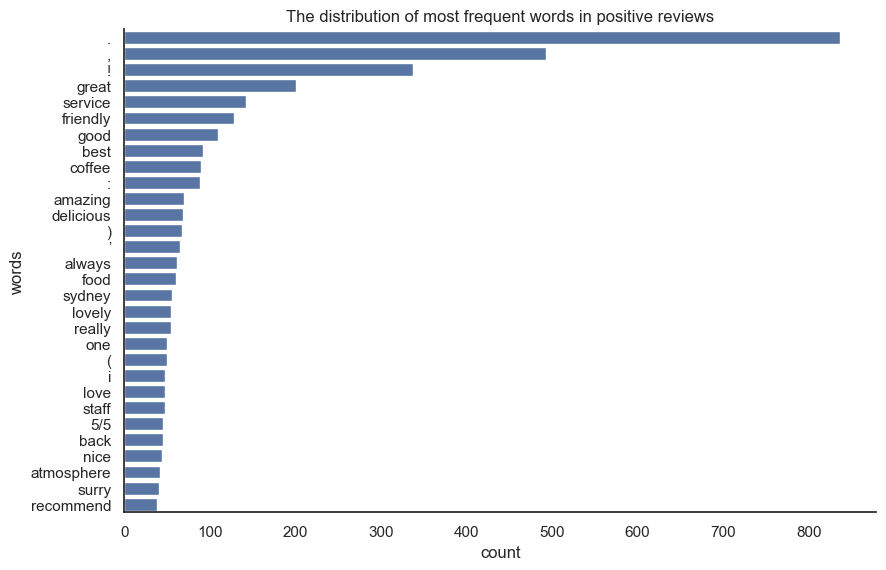

In [ ]:
df_pos = pd.DataFrame({'words':list(word_dist_pos.keys()),'count':list(word_dist_pos.values())})
df_po_plot = df_pos.nlargest(30,columns='count')

sns.barplot(data=df_po_plot,y='words',x='count').set_title('The distribution of most frequent words in positive reviews')
sns.despine()

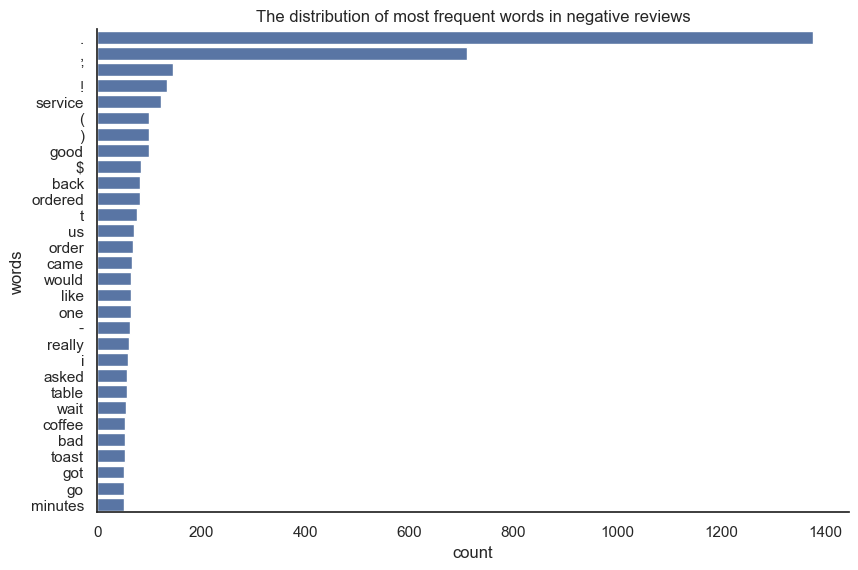

In [ ]:
## Let's do the same for negative sentiment
negative = data[data.sentiment == -1]
b = negative['tidy_snippet'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(b)
word_dist_neg = nltk.FreqDist(words)

df_neg = pd.DataFrame({'words':list(word_dist_neg.keys()),'count':list(word_dist_neg.values())})
df_neg_plot = df_neg.nlargest(30,columns='count')

sns.barplot(data=df_neg_plot, y='words',x='count').set_title('The distribution of most frequent words in negative reviews')
sns.despine()


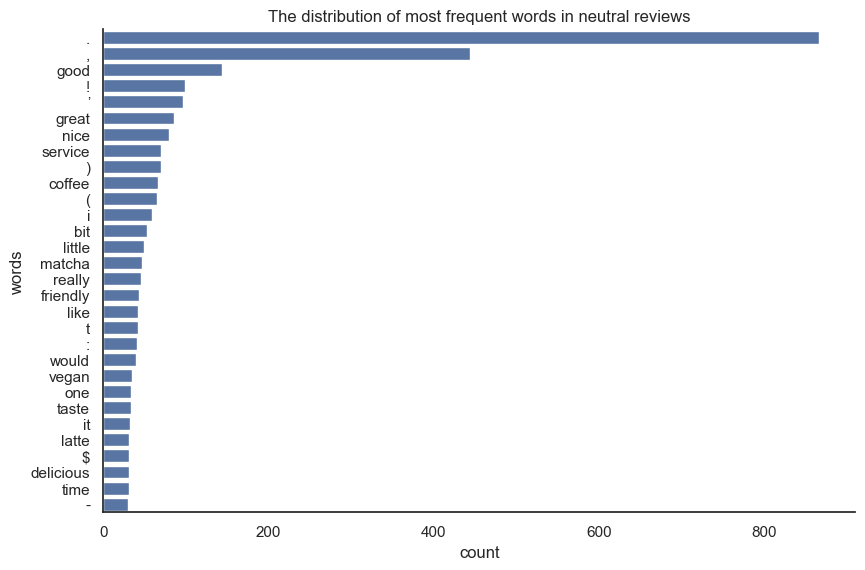

In [ ]:
## and neutral
neutral = data[data.sentiment == 0]
c = neutral['tidy_snippet'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(c)
word_dist_neu = nltk.FreqDist(words)

df_neu = pd.DataFrame({'words':list(word_dist_neu.keys()),'count':list(word_dist_neu.values())})
df_neu_plot = df_neu.nlargest(30,columns='count')

sns.barplot(data=df_neu_plot, y='words',x='count').set_title('The distribution of most frequent words in neutral reviews')
sns.despine()

### Building models

Different models will be examined:
- Multinomial Naive Bayes
- Logistic Regression
- Xgboost Classification

#### 1. Multinomial NB

Multionomial Naive Bayes will examined with 4 settings

In [ ]:
## Multinomial NB, Count Vectorizer, stemming
model1_nb =MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_count_vec_stem, y, test_size=0.3, random_state=100)
model1_nb.fit(X_train,y_train)

y_pred_nb_cv_st =model1_nb.predict(X_test)

cf1=classification_report(y_test,y_pred_nb_cv_st)
print(cf1)

accuracy_nb1 = accuracy_score(y_test,y_pred_nb_cv_st)
print('Accuracy Multinomial NB with Count Vectorizer and Data Stemming ' + str(round(accuracy_nb1,2)))

              precision    recall  f1-score   support

          -1       0.84      0.84      0.84       110
           0       0.66      0.45      0.54        82
           1       0.80      0.94      0.87       158

    accuracy                           0.79       350
   macro avg       0.77      0.74      0.75       350
weighted avg       0.78      0.79      0.78       350

Accuracy Multinomial NB with Count Vectorizer and Data Stemming 0.79


In [ ]:
## Multinomial NB, Count Vectorizer, lemmatization
model2_nb=MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_count_vec_lem,y,test_size=0.3, random_state=100)
model2_nb.fit(X_train,y_train)

y_pred_cv_lem =model2_nb.predict(X_test)

cf2=classification_report(y_test,y_pred_cv_lem)
print(cf2)

accuracy_nb2 = accuracy_score(y_test,y_pred_cv_lem)
print('Accuracy Multinomial NB with Count Vectorizer and Data Lemmatization data ' + str(round(accuracy_nb2,2)))

              precision    recall  f1-score   support

          -1       0.84      0.77      0.81       110
           0       0.58      0.44      0.50        82
           1       0.79      0.94      0.86       158

    accuracy                           0.77       350
   macro avg       0.74      0.72      0.72       350
weighted avg       0.76      0.77      0.76       350

Accuracy Multinomial NB with Count Vectorizer and Data Lemmatization data 0.77


In [ ]:
## Multinomial NB, TF-IDF, stemming
model3_nb=MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_tfidf_stem,y,test_size=0.3, random_state=100)
model3_nb.fit(X_train,y_train)

y_pred_td_stem =model3_nb.predict(X_test)

cf3=classification_report(y_test,y_pred_td_stem)
print(cf3)

accuracy_nb3 = accuracy_score(y_test,y_pred_td_stem)
print('Accuracy Multinomial NB, TF-IDF, stemming ' + str(round(accuracy_nb3, 2)))

              precision    recall  f1-score   support

          -1       0.82      0.85      0.83       110
           0       0.90      0.22      0.35        82
           1       0.72      0.98      0.83       158

    accuracy                           0.76       350
   macro avg       0.81      0.68      0.67       350
weighted avg       0.79      0.76      0.72       350

Accuracy Multinomial NB, TF-IDF, stemming 0.76


In [ ]:
## Multinomial NB, TF-IDF, lemmatization data
model4_nb =MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_tfidf_lem,y,test_size=0.3, random_state=100)
model4_nb.fit(X_train,y_train)

y_pred_td_lem =model4_nb.predict(X_test)

cf4=classification_report(y_test,y_pred_td_lem)
print(cf4)

accuracy_nb4 = accuracy_score(y_test,y_pred_td_lem)
print('Accuracy Multinomial NB, TF-IDF, lemmatization data ' + str(round(accuracy_nb4, 2)))

              precision    recall  f1-score   support

          -1       0.81      0.81      0.81       110
           0       0.80      0.20      0.31        82
           1       0.71      0.99      0.83       158

    accuracy                           0.75       350
   macro avg       0.77      0.66      0.65       350
weighted avg       0.76      0.75      0.70       350

Accuracy Multinomial NB, TF-IDF, lemmatization data 0.75


According to the accuracy, data prepared with Data Stemming and Count Vectorizer produces better outcome. Thus, next models will be built with these settings only.


In [ ]:
X_train,X_test,y_train,y_test =train_test_split(X_count_vec_stem,y,test_size=0.3, random_state=100)

## 2. Logistic Regression

In [ ]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train,y_train)

y_pred_count_stem_lr =lr.predict(X_test)
print(classification_report(y_pred_count_stem_lr,y_test))

accuracy_lr = accuracy_score(y_test,y_pred_count_stem_lr)
print('Accuracy Logistic Regression' + str(round(accuracy_lr,2)))

              precision    recall  f1-score   support

          -1       0.68      0.81      0.74        93
           0       0.50      0.48      0.49        86
           1       0.87      0.81      0.84       171

    accuracy                           0.73       350
   macro avg       0.69      0.70      0.69       350
weighted avg       0.73      0.73      0.73       350

Accuracy Logistic Regression0.73


Let's plot result to compare the outcomes

In [ ]:
results = pd.DataFrame({'model':['Multinomial Naive Bayes',
                                 'Multinomial Logistic Regression'],
                        'accuracy': [accuracy_nb1, accuracy_lr]})

In [ ]:
results['accuracy'] = results['accuracy'].apply(lambda x: round(x, 2))

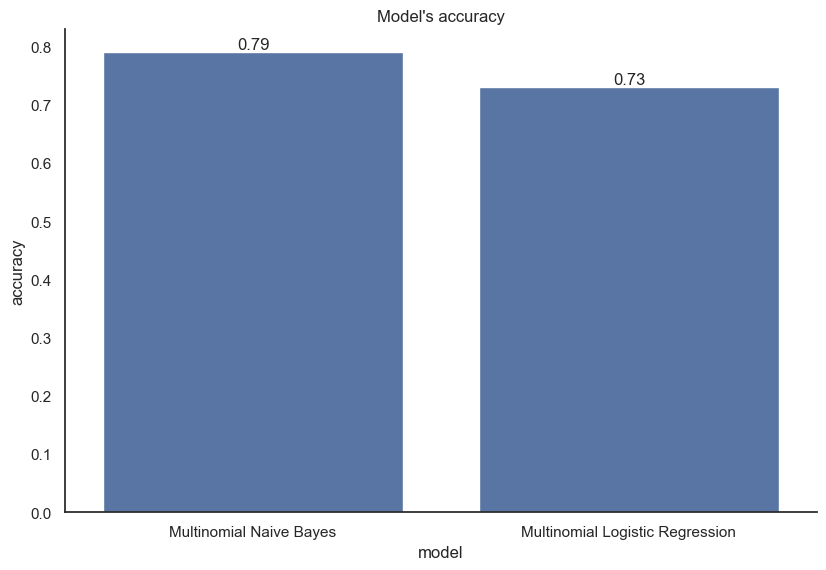

In [ ]:

ax = sns.barplot(data=results, x='model', y="accuracy")
ax.bar_label(ax.containers[0])
ax.set(title="Model's accuracy")
sns.despine()

Multinomial Naive Bayes produce the most accurate results, so now we can test this model

First, I will prepare function that preprocess reviews

In [ ]:
def predict_sentiment(text):
    if text =='':
        print('Invalid input')
    else:
        punct = re.sub('[^a-zA-Z]',' ', text)
        stop = punct.lower().split()
        cleaned = [w for w in stop if w not in stop_words]
        steamed = [stemmer.stem(word) for word in cleaned]
        final = cv_stem.transform(steamed).toarray()
        prediction =  model1_nb.predict(final)
        if prediction[0] == 1:
            print( "Positive" )
        elif prediction[0] == 0:
            print( "Neutral")
        else:
            print( "Negative")

In [ ]:
predict_sentiment('very good place')
# Correct!

Positive


In [ ]:
predict_sentiment('Charged me $8 for this. The highlight was the lemon. Making toast can be hard, but maybe you should practice a few times before you open a cafe. Good luck.')
# Correct!

Negative


In [ ]:
predict_sentiment('2018 went in for a coffee, both my husband and I threw out the coffee - lucky we took our own takeaway cup.  No longer a top coffee spot in sydney.')
# Correct!

Negative


In [ ]:
predict_sentiment('Had a delicious coffee to accompany some perfect scrambled eggs, sautéed mushrooms laid on a fresh croissant. It tasted as good as it looks in this picture! Nice ambience with plenty of seats. Will definitely visit again!')
# Correct!

Positive


In [ ]:
predict_sentiment('Cheese omelette & mushrooms omelette are quite salty. but cutlery looks nice')
#Could be neutral

Positive


In [ ]:
predict_sentiment('A nice small and intimate cafe. Good food and atmosphere.')
#Correct!

Neutral


In [ ]:
predict_sentiment('Bring back the German food. It used to be a favourite place to dine, but the only great thing here now is the coffee. Alas, the meals are too big, and although pleasant enough, just as good as I make at home. I go out to try better food that will surprise me and bring me back, and I expect food to match the name. It could have been called Cabramatta Bakr')
#Correct!

Negative


In [ ]:
predict_sentiment('On average it is a good place, but could be better coffee')
#Could be neutral, as well

Negative


So model performs  and perfectly distinct positive VS negative sentiments.
But it has some issues with neutral reviews. There could be several reasons behind this:
    - it was the smallest part in  training set
    - it is enormously subjective topic, and it also depends on the way how labels were assigned to scores. Maybe score 4 should also reflect positive attitude, and only score 3 should be assigned with neutral sentiment. As an illustration, some reviews can sound totally positive but the rating was 4 thus 'neutral sentiment' was assigned.
    - Perhaps, manual sentiment assignment can be handy.




## Summary

To achieve purpose of this project several steps were performed:
    1.Data exploration
    2.Data preprocessing
    3.Data visualization
    4.Modeling
    5.Testing
    6.Attempt of improvements

The best model: Multinomial Naive Bayes build on 70% of dataset (prepared with Data Stemming and Count Vectorizer) has 79% of accuracy.

Obviously there is a place for improvements:
-   size of the dataset can be increased
-   other models can be examined
-   different approaches for labels assignment can be tried
-   parametr tunning and k-fold cross validation can be handy

